In [63]:
! pip install -U scikit-fuzzy matplotlib numpy scipy networkx


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import numpy as np

def left_shoulder(x, a, b):
    # Ensure x is a NumPy array for vectorized operations
    x = np.asarray(x)

    # Initialize output array
    y = np.zeros_like(x, dtype=float)

    # Region 1: x > b -> 0 (already zero-initialized)
    # Region 2: b >= x >= a -> linear ramp
    in_ramp = (x >= a) & (x <= b)
    y[in_ramp] = (x[in_ramp] - b) / (a - b)

    # Region 3: x < a -> 1
    below_a = x < a
    y[below_a] = 1.0

    return y

def right_shoulder(x, a, b):
    # Ensure x is a NumPy array for vectorized operations
    x = np.asarray(x)

    # Initialize output array
    y = np.zeros_like(x, dtype=float)

    # Region 1: x < a -> 0 (already zero-initialized)
    # Region 2: a <= x <= b -> linear ramp
    in_ramp = (x >= a) & (x <= b)
    y[in_ramp] = (x[in_ramp] - a) / (b - a)

    # Region 3: x > b -> 1
    above_b = x > b
    y[above_b] = 1.0

    return y


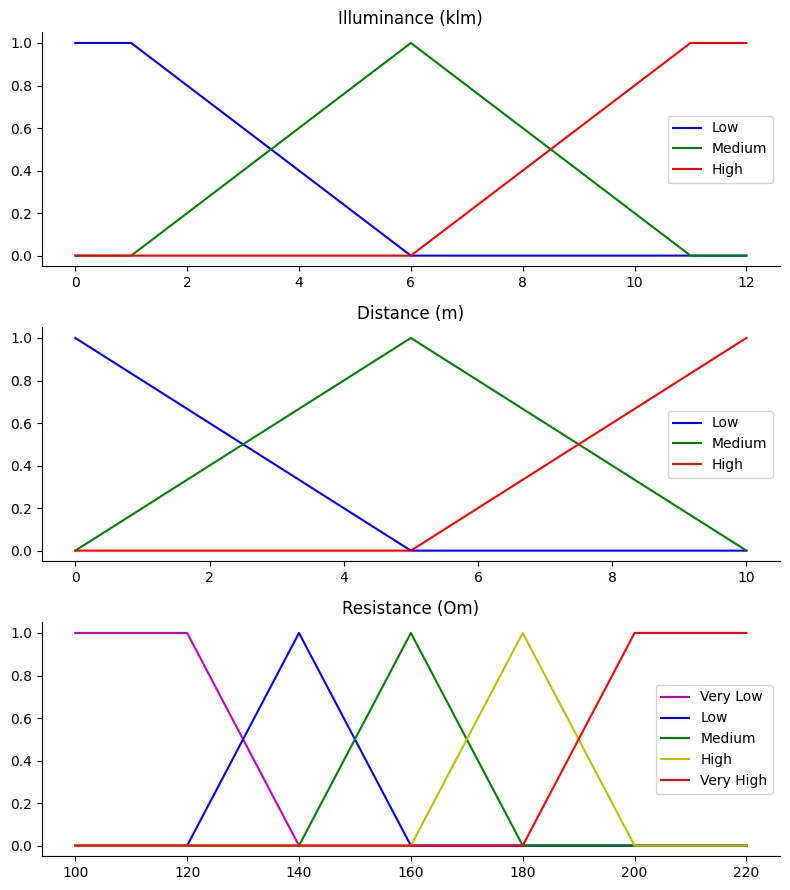

In [65]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate universe variables
#   * Illuminance on range 0..12 klm
#   * Distance on range 0..10 m
#   * Resistance on range 0..220 Ω
x_illum = np.linspace(0., 12., num=120 + 1) 
x_dist = np.linspace(0., 10., num=100 + 1)
x_res  = np.linspace(100., 220., num=120 + 1)

# Generate fuzzy membership functions
illum_lo = left_shoulder(x_illum, 1, 6)
illum_md = fuzz.trimf(x_illum, [1, 6, 11])
illum_hi = right_shoulder(x_illum, 6, 11)
dist_lo = left_shoulder(x_dist, 0, 5)
dist_md = fuzz.trimf(x_dist, [0, 5, 10])
dist_hi = right_shoulder(x_dist, 5, 10)
res_vlo = left_shoulder(x_res, 120, 140)
res_lo = fuzz.trimf(x_res, [120, 140, 160])
res_md = fuzz.trimf(x_res, [140, 160, 180])
res_hi = fuzz.trimf(x_res, [160, 180, 200])
res_vhi = right_shoulder(x_res, 180, 200)

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_illum, illum_lo, 'b', linewidth=1.5, label='Low')
ax0.plot(x_illum, illum_md, 'g', linewidth=1.5, label='Medium')
ax0.plot(x_illum, illum_hi, 'r', linewidth=1.5, label='High')
ax0.set_title('Illuminance (klm)')
ax0.legend()

ax1.plot(x_dist, dist_lo, 'b', linewidth=1.5, label='Low')
ax1.plot(x_dist, dist_md, 'g', linewidth=1.5, label='Medium')
ax1.plot(x_dist, dist_hi, 'r', linewidth=1.5, label='High')
ax1.set_title('Distance (m)')
ax1.legend()

ax2.plot(x_res, res_vlo, 'm', linewidth=1.5, label='Very Low')
ax2.plot(x_res, res_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_res, res_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_res, res_hi, 'y', linewidth=1.5, label='High')
ax2.plot(x_res, res_vhi, 'r', linewidth=1.5, label='Very High')
ax2.set_title('Resistance (Om)')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

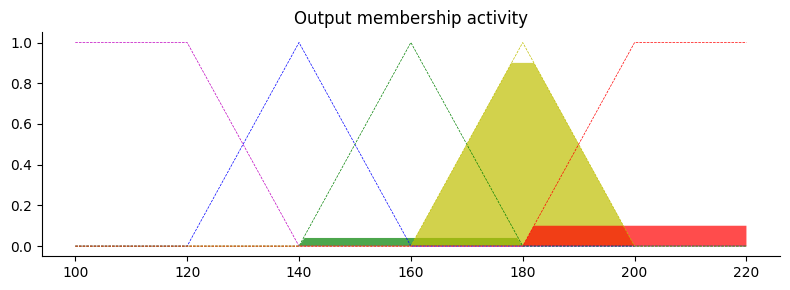

In [66]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
illum_value = 6.5 # klx
dist_value = 9.8 # m

illum_level_lo = fuzz.interp_membership(x_illum, illum_lo, illum_value)
illum_level_md = fuzz.interp_membership(x_illum, illum_md, illum_value)
illum_level_hi = fuzz.interp_membership(x_illum, illum_hi, illum_value)

dist_level_lo = fuzz.interp_membership(x_dist, dist_lo, dist_value)
dist_level_md = fuzz.interp_membership(x_dist, dist_md, dist_value)
dist_level_hi = fuzz.interp_membership(x_dist, dist_hi, dist_value)

# Now we take our rules and apply them. Rule 1 concerns low illuminance AND distance.
# The AND operator means we take the minimum of these two.
active_rule1 = np.fmin(illum_level_lo, dist_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
res_activation_vlo = np.fmin(active_rule1, res_vlo)  # removed entirely to 0

# For rule 2 we connect (low illuminance AND medium distance) or vice versa with low resistance
res_activation_lo = np.fmin(
    np.fmax(
        np.fmin(illum_level_lo, dist_level_md),
        np.fmin(illum_level_md, dist_level_lo)
    )
, res_lo)

# For rule 3 we connect "average cases" with medium resistance
active_rule3 = np.fmax(
    np.fmax(
        np.fmin(illum_level_lo, dist_level_hi),
        np.fmin(illum_level_md, dist_level_md)
    ),
    np.fmin(illum_level_hi, dist_level_lo)
)
res_activation_md = np.fmin(active_rule3, res_md)

res_activation_hi = np.fmin(
    np.fmax(
        np.fmin(illum_level_hi, dist_level_md),
        np.fmin(illum_level_md, dist_level_hi)
    )
, res_hi)

res_activation_vhi = np.fmin(
    np.fmin(illum_level_hi, dist_level_hi),
    res_vhi
)

res0 = np.zeros_like(x_res)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_res, res0, res_activation_vlo, facecolor='m', alpha=0.7)
ax0.plot(x_res, res_vlo, 'm', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_res, res0, res_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_res, res_lo, 'b', linewidth=0.5, linestyle='--')
ax0.fill_between(x_res, res0, res_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_res, res_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_res, res0, res_activation_hi, facecolor='y', alpha=0.7)
ax0.plot(x_res, res_hi, 'y', linewidth=0.5, linestyle='--')
ax0.fill_between(x_res, res0, res_activation_vhi, facecolor='r', alpha=0.7)
ax0.plot(x_res, res_vhi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()



resistance: 181.68869309838445


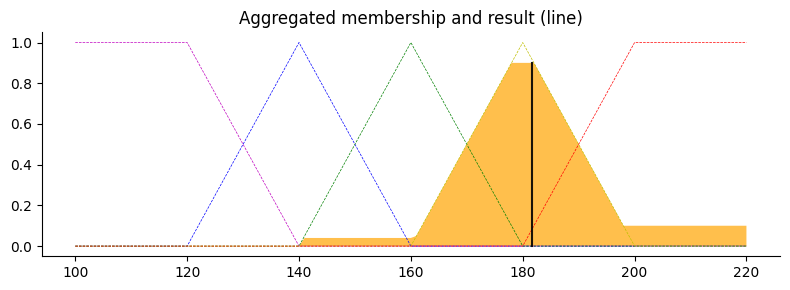

In [67]:
# Aggregate all five output membership functions together
aggregated = np.fmax(
    np.fmax(
        np.fmax(
            res_activation_vlo,
            res_activation_lo
        ),
        np.fmax(
            res_activation_md,
            res_activation_hi
        )
    ),
    res_activation_vhi
)

# Calculate defuzzified result
res = fuzz.defuzz(x_res, aggregated, 'centroid')
res_activation = fuzz.interp_membership(x_res, aggregated, res)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_res, res_vlo, 'm', linewidth=0.5, linestyle='--', )
ax0.plot(x_res, res_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_res, res_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_res, res_hi, 'y', linewidth=0.5, linestyle='--')
ax0.plot(x_res, res_vhi, 'r', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_res, res0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([res, res], [0, res_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

print(f'resistance: {res}')


181.68145407563983


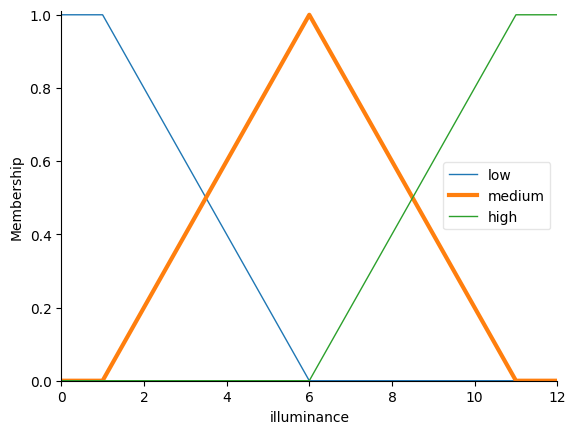

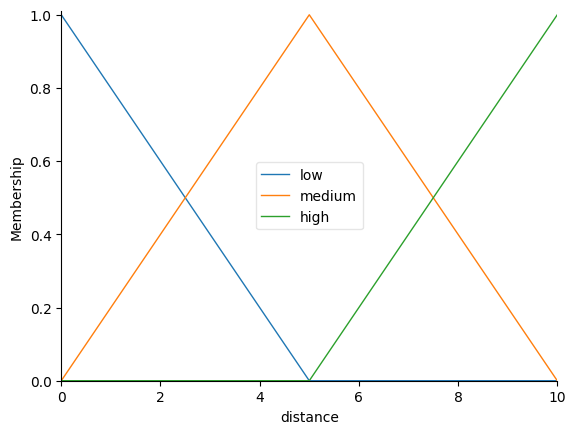

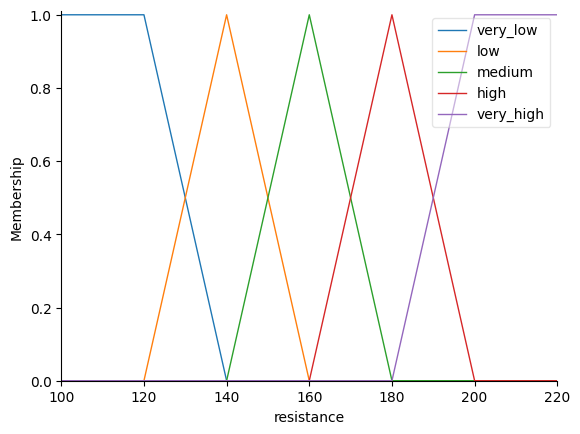

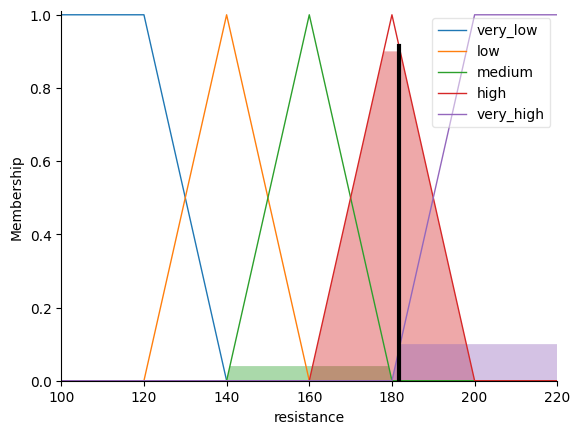

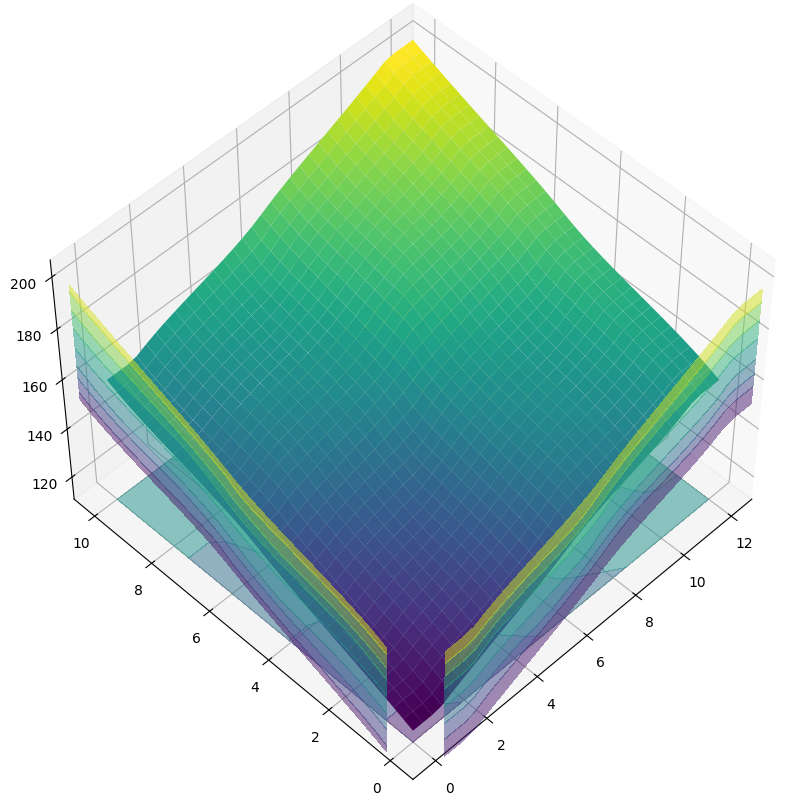

In [70]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Cоздаем нечеткие переменные, которые будут частью условия (антецеденты)
# Antecedent (вход / датчик) переменная для нечёткой системы управления.
# skfuzzy.control.Antecedent(массив/список одномерный конвертируемый в NumPy, метка / название)
# Для задания массива функцию arange(стартовое значение, конечное значение, шаг),
# этот массив определяет универсум лингвистической переменной (массив четких значений)
# Задаются 2 входные и 1 выходная лингвистическая переменная

illum = ctrl.Antecedent(np.linspace(0., 12., num=120 + 1) , 'illuminance')
dist = ctrl.Antecedent(np.linspace(0., 10., num=100 + 1) , 'distance')
res = ctrl.Consequent(np.linspace(100., 220., num=120 + 1) , 'resistance')

illum['low'] = left_shoulder(x_illum, 1, 6)
illum['medium'] = fuzz.trimf(x_illum, [1, 6, 11])
illum['high'] = right_shoulder(x_illum, 6, 11)

dist['low'] = left_shoulder(x_dist, 0, 5)
dist['medium'] = fuzz.trimf(x_dist, [0, 5, 10])
dist['high'] = right_shoulder(x_dist, 5, 10)

# Задаем выходную переменную через треугольную функцию
res['very_low'] = left_shoulder(res.universe, 120, 140)
res['low'] = fuzz.trimf(res.universe, [120, 140, 160])
res['medium'] = fuzz.trimf(res.universe, [140, 160, 180])
res['high'] = fuzz.trimf(res.universe, [160, 180, 200])
res['very_high'] = right_shoulder(res.universe, 180, 200)

# визуализируем переменные
illum['medium'].view()
dist.view()
res.view()

rules = [
    ctrl.Rule(illum['low'] & dist['low'], res['very_low']),
    ctrl.Rule(
        (illum['low'] & dist['medium']) | (illum['medium'] & dist['low']),
        res['low']
    ),
    ctrl.Rule(
        (illum['low'] & dist['high']) | (illum['medium'] & dist['medium']) | (illum['high'] & dist['low']),
        res['medium']
    ),
    ctrl.Rule(
        (illum['high'] & dist['medium']) | (illum['medium'] & dist['high']),
        res['high']
    ),
    ctrl.Rule(illum['high'] & dist['high'], res['very_high']),
]

# Создаем базу из 3 правил
resistance_ctrl = ctrl.ControlSystem(rules)
# Визуализация не работает
# resistance_ctrl.view()
# Создаем модель расчёта
resistance = ctrl.ControlSystemSimulation(resistance_ctrl)
# Подаем на вход четкие числа
resistance.input['illuminance'] = 6.5
resistance.input['distance'] = 9.8
# запускаем расчет
resistance.compute()
# Печатаем результат
print (resistance.output['resistance'])
# выводим результат в виде графика
res.view(sim=resistance)

# Для 3D-визуализации поверхности:
# Создаем прямоугольную сетку входных значений
x, y = np.meshgrid(
    np.linspace(0., 12., num=33),
    np.linspace(0., 10., num=33)
)
z = np.zeros_like(x)
# Заполняем z значениями выхода, вычисляемым для каждого сочетания входных переменных
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        resistance.input['illuminance'] = x[i, j]
        resistance.input['distance'] = y[i, j]
        resistance.compute()
        z[i, j] = resistance.output['resistance']

# Строим 3D график
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)
# Добавляем проекции контуров
ax.contourf(x, y, z, zdir='z', offset=np.min(z)-5, cmap='viridis', alpha=0.5)
ax.contourf(x, y, z, zdir='x', offset=np.min(x)-1, cmap='viridis', alpha=0.5)
ax.contourf(x, y, z, zdir='y', offset=np.min(y)-1, cmap='viridis', alpha=0.5)
ax.view_init(50, 225)
plt.show()

illuminance: 0.29058072950614067, distance: 4.970043786560927
resistance: 139.8184255603785
illuminance: 2.619783382131623, distance: 4.243288526649067
resistance: 142.83264300818752
illuminance: 2.423901862165049, distance: 8.718499611998624
resistance: 160.480774486048
illuminance: 8.870139546194, distance: 1.2681615608731789
resistance: 157.3298708121426
illuminance: 6.629179538307742, distance: 5.373352196400384
resistance: 166.29405683098608


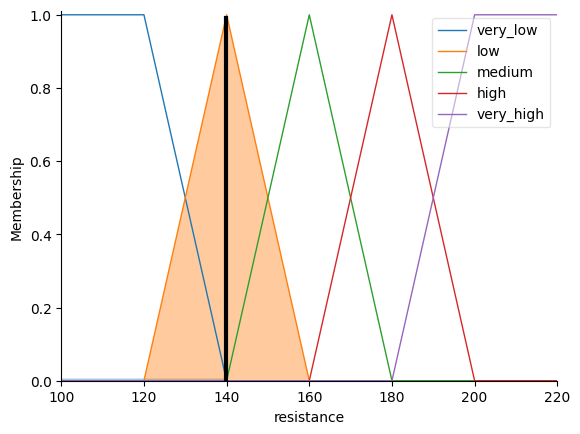

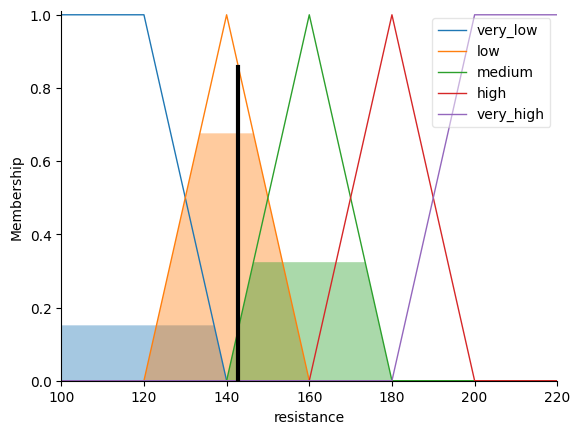

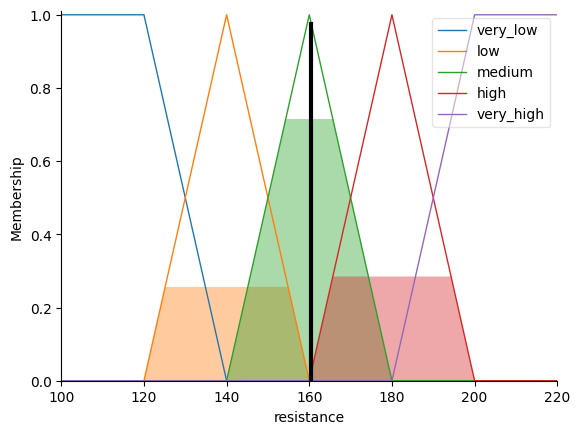

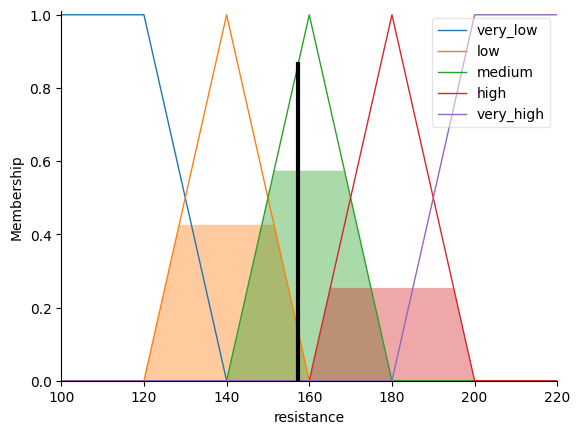

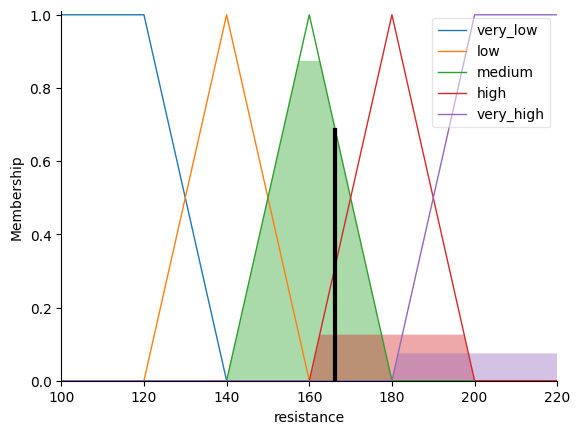

In [73]:
# Generate 5 random pairs
illum_dist_pairs = [
    (
        np.random.uniform(low=0., high=12.),
        np.random.uniform(low=0., high=10.),
    ) for _ in range(5)
]

for pair in illum_dist_pairs:
    illum_value, dist_value = pair
    print(f'illuminance: {illum_value}, distance: {dist_value}')
    
    # Assuming we have the computation model initialized
    resistance.input['illuminance'] = illum_value
    resistance.input['distance'] = dist_value
    resistance.compute()
    res_value = resistance.output['resistance']
    
    print(f'resistance: {resistance.output["resistance"]}')
    
    res.view(sim=resistance)